In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../')
import ndrought.drought_network as dnet

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

/pool0/data/steinjao/drought/drought_impact/notebooks/quality_control/../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
usdm = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/usdm/USDM_CONUS_105W_20000104_20220412.nc')

In [3]:
usdm_net = dnet.DroughtNetwork.unpickle('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet/USDM_net.pickle')

In [4]:
dt_path = '/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/drought_tracks'

In [5]:
with open(f'{dt_path}/USDM_tracks.pickle', 'rb') as f:
    unpickler = pickle.Unpickler(f)
    usdm_dt = unpickler.load()

In [6]:
usdm_dtd = dict()
vars = ['x', 'y', 'u', 'v', 't', 'c', 'a']

for tracks, var in zip(usdm_dt, vars):
    var_tracks = []
    for track in tracks:
        var_tracks.append(np.array(track))
    usdm_dtd[var] = var_tracks

In [7]:
def to_y(y, y_meta):
    y_min, y_max, y_spacing = y_meta
    return ((y_min-y_max)/y_spacing)*(y)+y_max

def to_x(x, x_meta):
    x_min, x_max, x_spacing = x_meta
    return ((x_max-x_min)/x_spacing)*(x)+x_min

def to_xy(coord, coord_meta):
    y_min, y_max, y_spacing, x_min, x_max, x_spacing = coord_meta

    y_meta = (y_min, y_max, y_spacing)
    x_meta = (x_min, x_max, x_spacing)

    y, x = coord
    return (to_x(x, x_meta), to_y(y, y_meta))

In [8]:
x_coords = usdm['USDM'].x.values
y_coords = usdm['USDM'].y.values

coord_meta = (
    np.min(y_coords), np.max(y_coords), len(y_coords),
    np.min(x_coords), np.max(x_coords), len(x_coords)
)

In [9]:
net_centroids = {node.id:(*to_xy(node.coords.mean(axis=0), coord_meta), node.time, len(node.coords)) for node in usdm_net.nodes}

In [10]:
net_centroids[0]

(-861644.6939304064, 893155.1802499737, 1, 3)

In [11]:
centroids_x = []
centroids_y = []

for node in usdm_net.nodes:
    centroids_x.append(net_centroids[node.id][0])
    centroids_y.append(net_centroids[node.id][1])

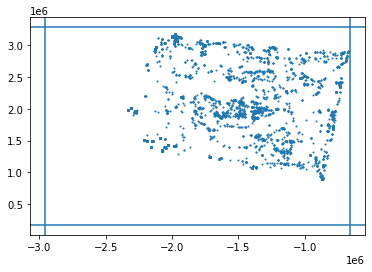

In [13]:
fig, ax = plt.subplots()

ax.axhline(np.min(y_coords))
ax.axhline(np.max(y_coords))
ax.axvline(np.min(x_coords))
ax.axvline(np.max(x_coords))

ax.scatter(centroids_x, centroids_y, s=1)

Okay, so the centroids all fall within the expected bounds ...

In [17]:
all_x_track = np.hstack(usdm_dtd['x'])
all_y_track = np.hstack(usdm_dtd['y'])
all_u_track = np.hstack(usdm_dtd['u'])
all_v_track = np.hstack(usdm_dtd['v'])

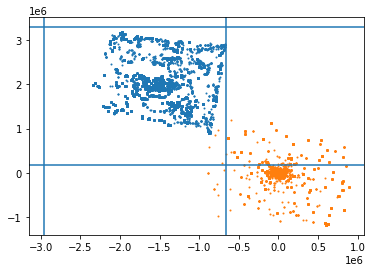

In [21]:
fig, ax = plt.subplots()

ax.axhline(np.min(y_coords))
ax.axhline(np.max(y_coords))
ax.axvline(np.min(x_coords))
ax.axvline(np.max(x_coords))

ax.scatter(all_x_track, all_y_track, s=1)
ax.scatter(all_u_track, all_v_track, s=1)

AH!

That looks like a translation issue.

OH WAIT. THEYRE VECTORS

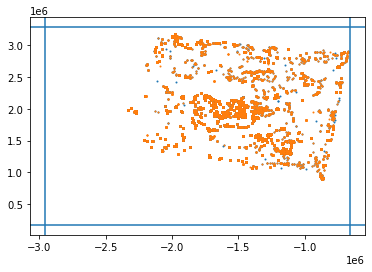

In [22]:
fig, ax = plt.subplots()

ax.axhline(np.min(y_coords))
ax.axhline(np.max(y_coords))
ax.axvline(np.min(x_coords))
ax.axvline(np.max(x_coords))

ax.scatter(all_x_track, all_y_track, s=1)
ax.scatter(all_u_track+all_x_track, all_v_track+all_y_track, s=1)

There we go